In [ ]:
import pandas as pd
import re 
import spacy
import gensim
import nltk
import os
from sklearn.metrics import mean_squared_error as mse 
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.tokenize    import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize      import word_tokenize #sent_tokenize,
from nltk.corpus        import stopwords, PlaintextCorpusReader
from nltk               import ngrams

from sklearn import preprocessing
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt 
import os
import pandas            as pd
import pysentiment2      as ps

import gensim.corpora    as corpora
from gensim.utils       import  simple_preprocess
#from sklearn.manifold   import TSNE
from wordcloud          import WordCloud
from pprint             import pprint

from matplotlib.patches import Rectangle
from matplotlib.ticker  import FuncFormatter


In [ ]:
all_reviews = pd.read_csv('all_reviews.csv')
all_reviews['comments'] = all_reviews['comments'].astype(str)

In [ ]:
dataset = all_reviews.drop(columns=['listing_id'])
dataset.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

for col in dataset.columns:
    dataset[col] = dataset[col].str.lower()
dataset


,comments
0,paddy was extremely responsive and accommodati...
1,i had a great time staying with paddy she is ...
2,pretty apartment that was the perfect location...
3,awesome hosts very friendly the house is loc...
4,todd and amy were fantastic hosts and we had ...
...,...
3316,charles place was nice and cozy it was perfec...
3317,modern clean property within walking distance...
3318,this place is super convenience and totally wo...
3319,great price super close to public transportat...


In [ ]:
dataset = dataset[['comments']].apply(lambda x: ''.join(x), axis=1)

def sent_to_words(sentence):
    for sent in sentence:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

datawords = list(sent_to_words(dataset))

In [ ]:
print(datawords[:1])


[['paddy', 'was', 'extremely', 'responsive', 'and', 'accommodating', 'we', 'would', 'definitely', 'stay', 'again', 'paddy', 'was', 'helpful', 'with', 'orientation', 'and', 'warning', 'us', 'of', 'perils', 'of', 'austin', 'rush', 'hour', 'house', 'was', 'clean', 'and', 'outdoor', 'space', 'was', 'nice', 'addition', 'we', 'stayed', 'at', 'paddy', 'for', 'acl', 'and', 'it', 'couldn', 'have', 'worked', 'out', 'better', 'paddy', 'house', 'was', 'perfect', 'for', 'four', 'people', 'to', 'share', 'and', 'close', 'to', 'everything', 'we', 'wanted', 'to', 'do', 'in', 'austin', 'we', 'had', 'some', 'timing', 'issues', 'on', 'our', 'part', 'for', 'arrival', 'and', 'paddy', 'was', 'very', 'accommodating', 'overall', 'it', 'was', 'great', 'experience', 'we', 'loved', 'staying', 'at', 'paddy', 'peaceful', 'charming', 'house', 'it', 'is', 'great', 'refuge', 'from', 'downtown', 'austin', 'we', 'made', 'last', 'minute', 'booking', 'and', 'paddy', 'went', 'out', 'of', 'her', 'way', 'to', 'accommodate', 

In [ ]:
# Build the bigram and trigram models
bigram      = gensim.models.Phrases(datawords, min_count=5, threshold=100) 
trigram     = gensim.models.Phrases(bigram[datawords], threshold=100)  
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
#Introduce stopping words
stop_words = set(stopwords.words('english'))
additional_stopwords = ['say','veri','wa','u','hi','ha','us','would','th','thi','also','and','hous']
#cities_stopwords = ['austin','orleans','asheville']
stop_words.update(additional_stopwords)
#stop_words.update(cities_stopwords)
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, 
                              allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    """
    texts = [[word for word in simple_preprocess(str(doc)) if word not in
                                                  stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    # A lemmatizer is preferred over a stemmer in this case because it 
    # produces more readable words. Output# that is easy to read is very 
    # desirable in topic modelling. 
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in
                                                              allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word 
                                      not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(datawords)  


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)


In [ ]:

corpus = [id2word.doc2bow(text) for text in data_ready]


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word        = id2word,
                                           num_topics     = 6, 
                                           random_state   = 100,
                                           update_every   = 1,
                                           chunksize      = 10,
                                           passes         = 25,
                                           alpha          = 'symmetric',
                                           #alpha          = 0.02,
                                           #eta            = 0.02,
                                           iterations     = 500,
                                           per_word_topics=True)


In [ ]:
pprint(lda_model.print_topics())


[(0,
  '0.080*"room" + 0.045*"stay" + 0.038*"host" + 0.027*"clean" + '
  '0.026*"friendly" + 0.023*"nice" + 0.019*"comfortable" + 0.018*"dog" + '
  '0.018*"private" + 0.018*"bathroom"'),
 (1,
  '0.000*"carli" + 0.000*"norense" + 0.000*"myra" + 0.000*"molly" + '
  '0.000*"blayne" + 0.000*"enrique" + 0.000*"karli" + 0.000*"pepp" + '
  '0.000*"erich" + 0.000*"rae"'),
 (2,
  '0.030*"great" + 0.028*"place" + 0.022*"stay" + 0.021*"quarter" + '
  '0.021*"new" + 0.019*"french" + 0.018*"walk" + 0.016*"location" + '
  '0.010*"street" + 0.009*"host"'),
 (3,
  '0.043*"home" + 0.036*"house" + 0.028*"stay" + 0.026*"beautiful" + '
  '0.021*"host" + 0.018*"love" + 0.017*"wonderful" + 0.015*"amazing" + '
  '0.014*"make" + 0.013*"back"'),
 (4,
  '0.048*"great" + 0.041*"place" + 0.035*"stay" + 0.026*"location" + '
  '0.021*"clean" + 0.013*"perfect" + 0.012*"need" + 0.012*"nice" + '
  '0.012*"definitely" + 0.011*"recommend"'),
 (5,
  '0.000*"carli" + 0.000*"norense" + 0.000*"myra" + 0.000*"molly" + '
  '0

In [ ]:
topic_df = pd.DataFrame(
    {
        'Topic 0': ["0.080*room" ,"0.045*stay" ,"0.038*host" ,"0.027*clean" ,
  "0.026*friendly" , "0.023*nice" , "0.019*comfortable" , "0.018*dog" ,
  "0.018*private" ,"0.018*bathroom"],
        'Topic 1': ["0.000*carli" , "0.000*norense" , "0.000*myra" ,"0.000*molly" ,
  "0.000*blayne" , "0.000*enrique" , "0.000*karli" , "0.000*pepp" ,
  "0.000*erich" , "0.000*rae"],
        'Topic 2':[ "0.030*great" , "0.028*place" , "0.022*stay" ,"0.021*quarter" , 
  "0.021*new" , "0.019*french" , "0.018*walk" , "0.016*location" ,
  "0.010*street" , "0.009*host"],
        'Topic 3':["0.043*home" , "0.036*house" , "0.028*stay" , "0.026*beautiful" ,
  "0.021*host" , "0.018*love" , "0.017*wonderful" , "0.015*amazing" ,
  "0.014*make" , "0.013*back"],
        'Topic 4':["0.048*great" ,"0.041*place" , "0.035*stay" , "0.026*location" ,
  "0.021*clean" , "0.013*perfect" , "0.012*need" , "0.012*nice" ,
  "0.012*definitely" , "0.011*recommend"],}
)
topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,0.080*room,0.000*carli,0.030*great,0.043*home,0.048*great
1,0.045*stay,0.000*norense,0.028*place,0.036*house,0.041*place
2,0.038*host,0.000*myra,0.022*stay,0.028*stay,0.035*stay
3,0.027*clean,0.000*molly,0.021*quarter,0.026*beautiful,0.026*location
4,0.026*friendly,0.000*blayne,0.021*new,0.021*host,0.021*clean
5,0.023*nice,0.000*enrique,0.019*french,0.018*love,0.013*perfect
6,0.019*comfortable,0.000*karli,0.018*walk,0.017*wonderful,0.012*need
7,0.018*dog,0.000*pepp,0.016*location,0.015*amazing,0.012*nice
8,0.018*private,0.000*erich,0.010*street,0.014*make,0.012*definitely
9,0.018*bathroom,0.000*rae,0.009*host,0.013*back,0.011*recommend


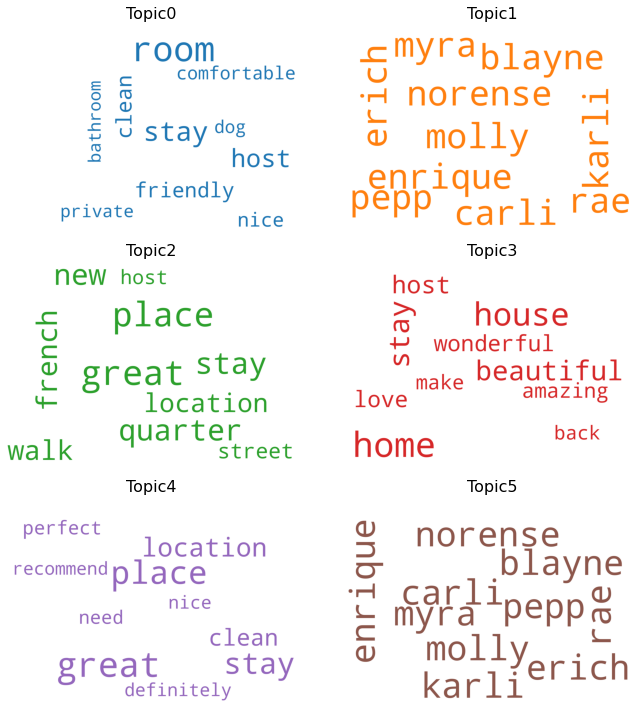

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stopwords,
                background_color='white',
                width=2500,
                height=1800,
                max_words=10,
                colormap='tab10',
                color_func=lambda*args, **kwargs: cols[i])

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontdict = dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
plt.savefig('word cluster.png')

<h2> LDA for negative sentiment

In [ ]:
poor_reviews = pd.read_csv('poor_rating_review.csv')
poor_reviews['comments'] = poor_reviews['comments'].astype(str)
dataset_pr = poor_reviews.drop(columns=['listing_id'])
dataset_pr.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

for col in dataset_pr.columns:
    dataset_pr[col] =dataset_pr[col].str.lower()

dataset_pr = dataset_pr[['comments']].apply(lambda x: ''.join(x), axis=1)

def sent_to_words(sentence):
    for sent in sentence:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

neg_datawords = list(sent_to_words(dataset_pr))


In [ ]:
# Build the bigram and trigram models
bigram      = gensim.models.Phrases(neg_datawords, min_count=5, threshold=100) 
trigram     = gensim.models.Phrases(bigram[neg_datawords], threshold=100)  
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
#Introduce stopping words
stop_words = set(stopwords.words('english'))
additional_stopwords = ['say','veri','wa','u','hi','ha','us','would','th','thi','also','and','hous']
positive_words = ['great','locat','highli','recommend','home','enjoy','stay','welcom','nice','stay','well','clean','good','comfort']
cities_stopwords = ['austin','orleans','asheville']
stop_words.update(additional_stopwords)
stop_words.update(cities_stopwords)
stop_words.update(positive_words)


neg_data_ready = process_words(neg_datawords, stop_words)  


In [ ]:
# Create Dictionary
neg_id2word = corpora.Dictionary(neg_data_ready)

neg_corpus = [neg_id2word.doc2bow(text) for text in neg_data_ready]


# Build LDA model
neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=neg_corpus,
                                           id2word        = neg_id2word,
                                           num_topics     = 6, 
                                           random_state   = 100,
                                           update_every   = 1,
                                           chunksize      = 10,
                                           passes         = 25,
                                           alpha          = 'symmetric',
                                           #alpha          = 0.02,
                                           #eta            = 0.02,
                                           iterations     = 500,
                                           per_word_topics=True)


In [ ]:
pprint(neg_lda_model.print_topics())


[(0,
  '0.058*"room" + 0.033*"people" + 0.027*"parking" + 0.022*"see" + '
  '0.017*"still" + 0.017*"quite" + 0.017*"cheaper" + 0.017*"bedroom" + '
  '0.017*"practical" + 0.017*"compare"'),
 (1,
  '0.034*"answer" + 0.034*"respond" + 0.034*"call" + 0.034*"airbnb" + '
  '0.018*"bnb" + 0.018*"website" + 0.018*"man" + 0.018*"choose" + '
  '0.018*"arrive" + 0.018*"weekend"'),
 (2,
  '0.054*"host" + 0.040*"reservation" + 0.040*"cancel" + 0.040*"arrival" + '
  '0.037*"place" + 0.035*"day" + 0.030*"posting" + 0.030*"automate" + '
  '0.025*"get" + 0.018*"go"'),
 (3,
  '0.039*"phone" + 0.023*"rent" + 0.023*"time" + 0.016*"never" + '
  '0.016*"suggest" + 0.016*"room" + 0.016*"know" + 0.012*"really" + '
  '0.012*"mean" + 0.012*"expect"'),
 (4,
  '0.022*"house" + 0.012*"quite" + 0.012*"paper" + 0.012*"overpriced" + '
  '0.012*"bit" + 0.012*"toilet" + 0.012*"attack" + 0.012*"neighborhood" + '
  '0.012*"cold" + 0.012*"friend"'),
 (5,
  '0.023*"towel" + 0.018*"hostel" + 0.018*"time" + 0.012*"make" + '


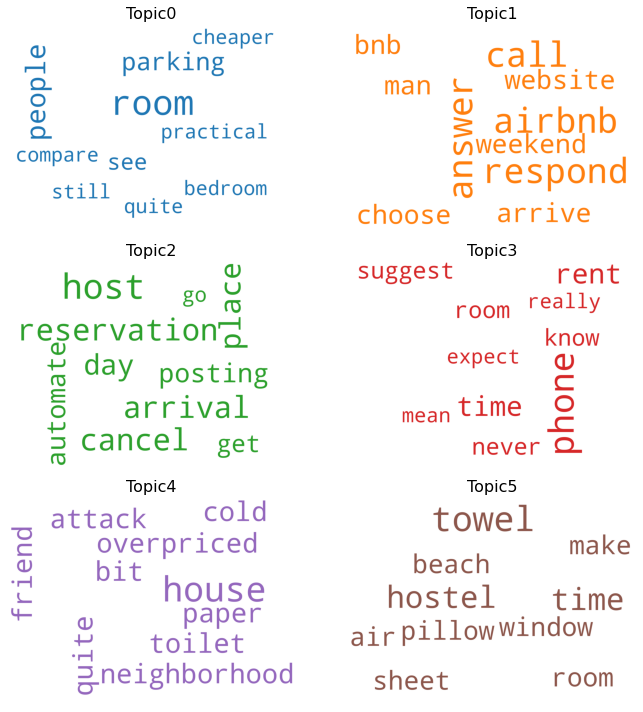

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                background_color='white',
                width=2500,
                height=1800,
                max_words=10,
                colormap='tab10',
                color_func=lambda*args, **kwargs: cols[i])

topics = neg_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontdict = dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
plt.savefig('neg word cluster.png')

<h2> Good Reviews

In [ ]:
good_reviews = pd.read_csv('good_rating_review.csv')
good_reviews['comments'] = good_reviews['comments'].astype(str)
dataset_gd = good_reviews.drop(columns=['listing_id'])
dataset_gd.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

dataset_gd[:10]


,comments
0,Paddy was extremely responsive and accommodati...
1,I had the most wonderful experience at Louise ...
2,I had a great time staying with Paddy She is ...
3,Pretty apartment that was the perfect location...
4,Jeg f lte mig velkommen fra f rste sekund og f...
5,Very zen and quiet space bringing nature in...
6,Awesome hosts Very friendly The house is loc...
7,Todd and Amy were fantastic hosts and we had ...
8,I absolutely loved my stay at Amy s studio apa...
9,Our hosts Heidi and Tom were so very welcoming...


In [ ]:
len(dataset_gd['comments'])

8181

In [ ]:
# for col in dataset_gd.columns:
#     dataset_gd[col] =dataset_gd[col].str.lower()
dataset_gd['comments'] = dataset_gd['comments'].str.lower()
dataset_gd = dataset_gd[['comments']].apply(lambda x: ''.join(x), axis=1)

def sent_to_words(sentence):
    for sent in sentence:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

pos_datawords = list(sent_to_words(dataset_gd))

In [ ]:
# Build the bigram and trigram models
bigram      = gensim.models.Phrases(pos_datawords, min_count=50, threshold=1000) 
trigram     = gensim.models.Phrases(bigram[pos_datawords], threshold=1000)  
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
#Introduce stopping words
stop_words = set(stopwords.words('english'))
additional_stopwords = ['say','veri','wa','u','hi','ha','us','would','th','thi','also','and','hous']
cities_stopwords = ['austin','orleans','asheville']
stop_words.update(additional_stopwords)
stop_words.update(cities_stopwords)


pos_data_ready = process_words(pos_datawords, stop_words)  

# Create Dictionary
pos_id2word = corpora.Dictionary(pos_data_ready)

pos_corpus = [pos_id2word.doc2bow(text) for text in pos_data_ready]


# Build LDA model
pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=pos_corpus,
                                           id2word        = pos_id2word,
                                           num_topics     = 6, 
                                           random_state   = 100,
                                           update_every   = 1,
                                           chunksize      = 10,
                                           passes         = 25,
                                           alpha          = 'symmetric',
                                           #alpha          = 0.02,
                                           #eta            = 0.02,
                                           iterations     = 500,
                                           per_word_topics=True)


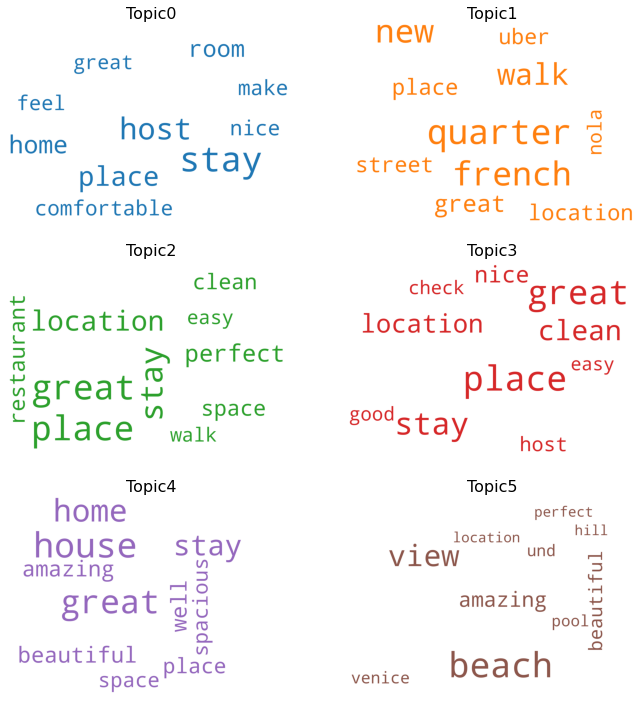

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                background_color='white',
                width=2500,
                height=1800,
                max_words=10,
                colormap='tab10',
                color_func=lambda*args, **kwargs: cols[i])

topics = pos_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontdict = dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
plt.savefig('positive word cluster.png')

In [ ]:
pprint(pos_lda_model.print_topics())


[(0,
  '0.040*"stay" + 0.029*"host" + 0.023*"place" + 0.019*"home" + 0.017*"room" + '
  '0.013*"nice" + 0.013*"make" + 0.013*"comfortable" + 0.013*"feel" + '
  '0.012*"great"'),
 (1,
  '0.051*"quarter" + 0.047*"french" + 0.045*"new" + 0.038*"walk" + '
  '0.022*"great" + 0.019*"place" + 0.019*"location" + 0.019*"street" + '
  '0.018*"uber" + 0.015*"nola"'),
 (2,
  '0.042*"great" + 0.041*"place" + 0.034*"stay" + 0.027*"location" + '
  '0.019*"perfect" + 0.016*"restaurant" + 0.015*"space" + 0.015*"clean" + '
  '0.012*"easy" + 0.012*"walk"'),
 (3,
  '0.043*"place" + 0.041*"great" + 0.035*"stay" + 0.028*"clean" + '
  '0.023*"location" + 0.018*"nice" + 0.014*"host" + 0.012*"good" + '
  '0.012*"check" + 0.011*"easy"'),
 (4,
  '0.028*"house" + 0.026*"great" + 0.022*"home" + 0.019*"stay" + '
  '0.010*"beautiful" + 0.010*"amazing" + 0.010*"well" + 0.009*"place" + '
  '0.009*"spacious" + 0.009*"space"'),
 (5,
  '0.085*"beach" + 0.060*"view" + 0.025*"amazing" + 0.019*"beautiful" + '
  '0.015*"veni

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e6d3dd7-a3ce-422e-8f25-57163d804f84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>